In [1]:
import os
import numpy as np
import keras
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

In [2]:
# Path to images and annotations
path_images = "./101_ObjectCategories/airplanes/"
path_annot = "./Annotations/Airplanes_Side_2/"

path_to_downloaded_file = keras.utils.get_file(
    fname="caltech_101_zipped",
    origin="https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip",
    extract=True,
    archive_format="zip",  # downloaded file format
    cache_dir="/",  # cache and extract in current directory
)
download_base_dir = os.path.dirname(path_to_downloaded_file)

# Extracting tar files found inside main zip file
shutil.unpack_archive(
    os.path.join(download_base_dir, "caltech-101", "101_ObjectCategories.tar.gz"), "."
)
shutil.unpack_archive(
    os.path.join(download_base_dir, "caltech-101", "Annotations.tar"), "."
)

# list of paths to images and annotations
image_paths = [
    f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))
]
annot_paths = [
    f for f in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, f))
]

image_paths.sort()
annot_paths.sort()

image_size = 224  # resize input images to this size

images, targets = [], []

# loop over the annotations and images, preprocess them and store in lists
for i in range(0, len(annot_paths)):
    # Access bounding box coordinates
    annot = scipy.io.loadmat(path_annot + annot_paths[i])["box_coord"][0]

    top_left_x, top_left_y = annot[2], annot[0]
    bottom_right_x, bottom_right_y = annot[3], annot[1]

    image = keras.utils.load_img(
        path_images + image_paths[i],
    )
    (w, h) = image.size[:2]

    # resize images
    image = image.resize((image_size, image_size))

    # convert image to array and append to list
    images.append(keras.utils.img_to_array(image))

    # apply relative scaling to bounding boxes as per given image and append to list
    targets.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )

# Convert the list to numpy array, split to train and test dataset
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)

137414764/137414764 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [3]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [4]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


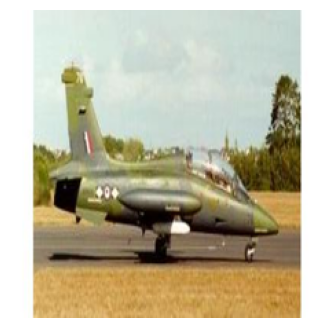

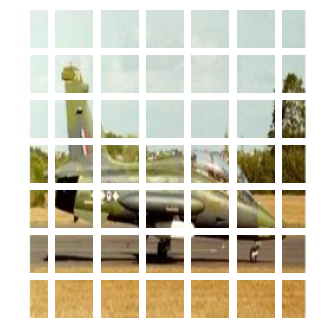

In [5]:
patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(np.expand_dims(x_train[0], axis=0))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [6]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded


In [7]:

def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = keras.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 214ms/step - loss: 1.2324 - val_loss: 0.2209
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.2949 - val_loss: 0.2290
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.2245 - val_loss: 0.0907
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.1484 - val_loss: 0.0066
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0823 - val_loss: 0.0027
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0468 - val_loss: 0.0033
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0359 - val_loss: 0.0058
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0332 - val_loss: 0.0017
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0322 - val_loss: 0.0033
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0316 - val_loss: 0.0014
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0251 - val_loss: 0.0020
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/st

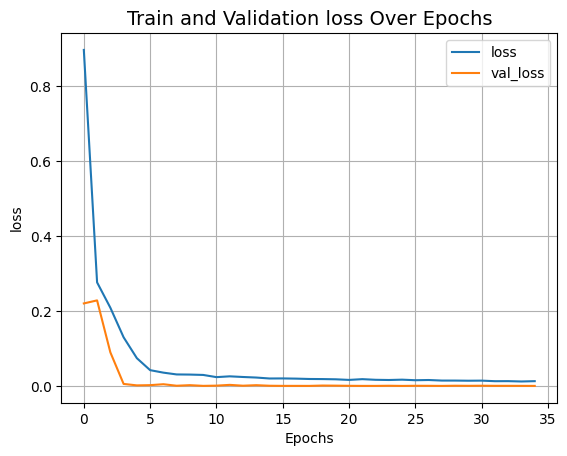

In [8]:

def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "vit_object_detector.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history


input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers


history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
mean_iou: 0.8850011986070105


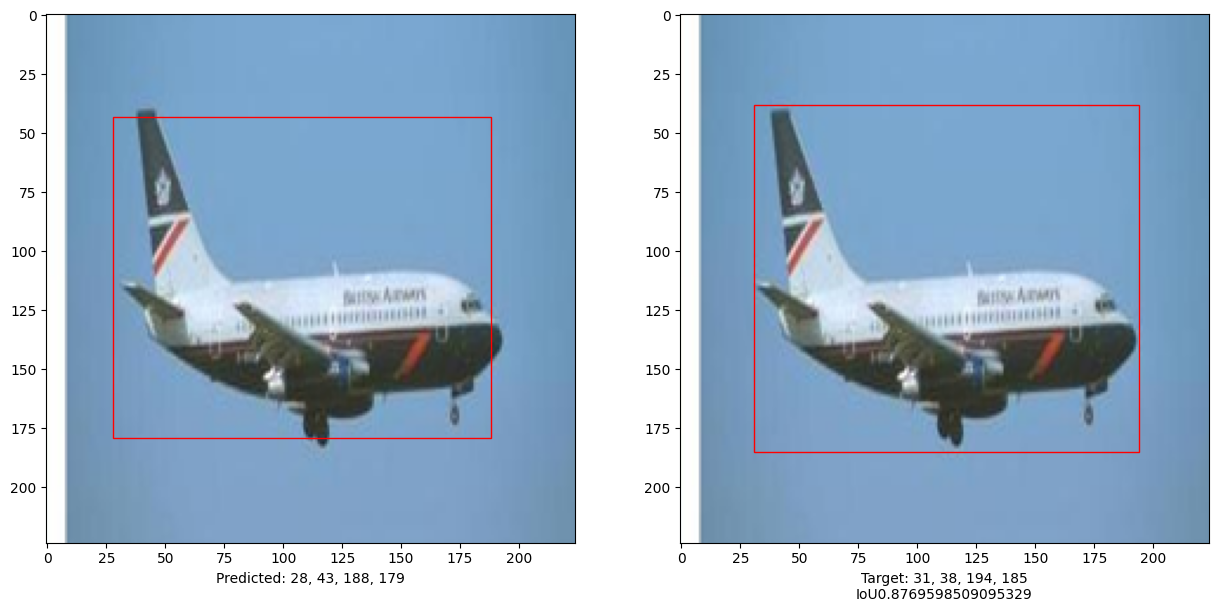

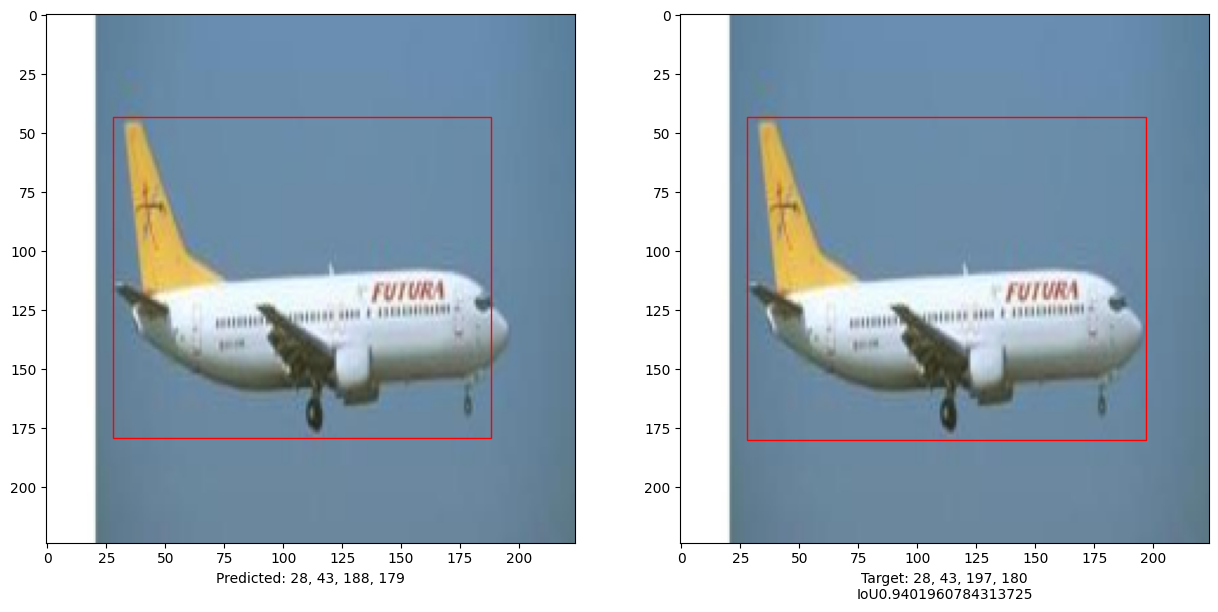

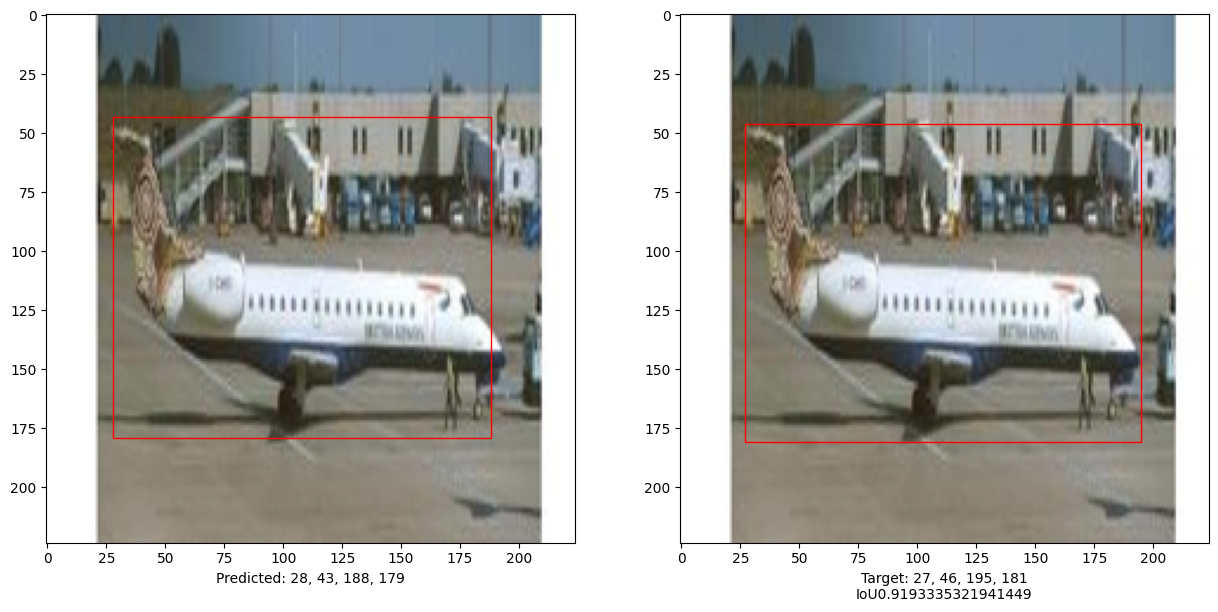

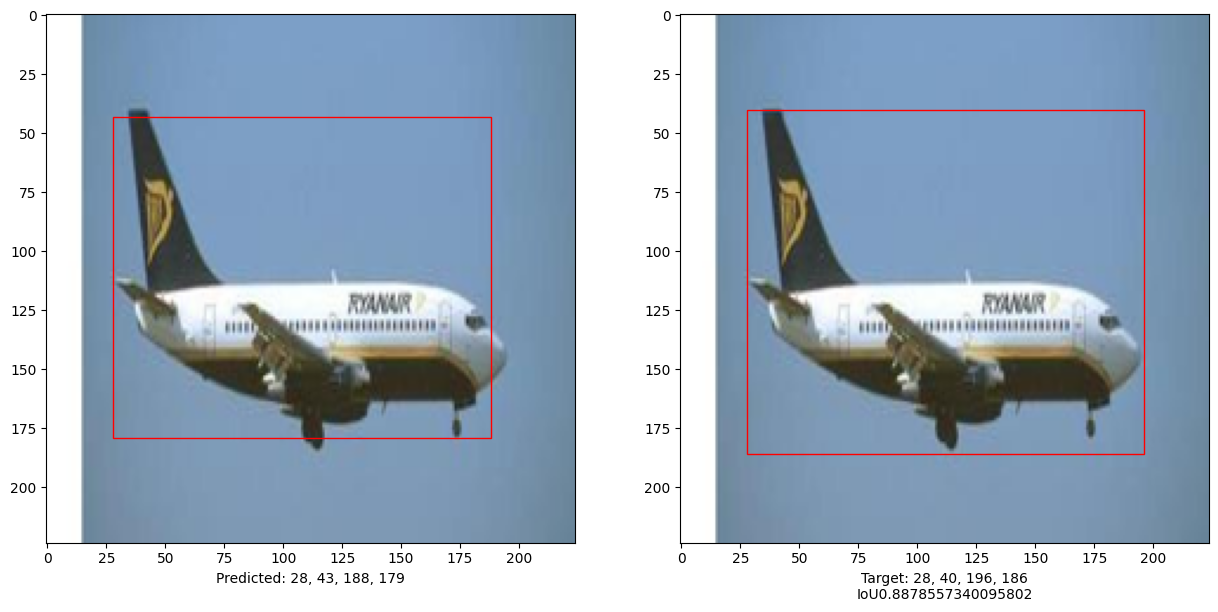

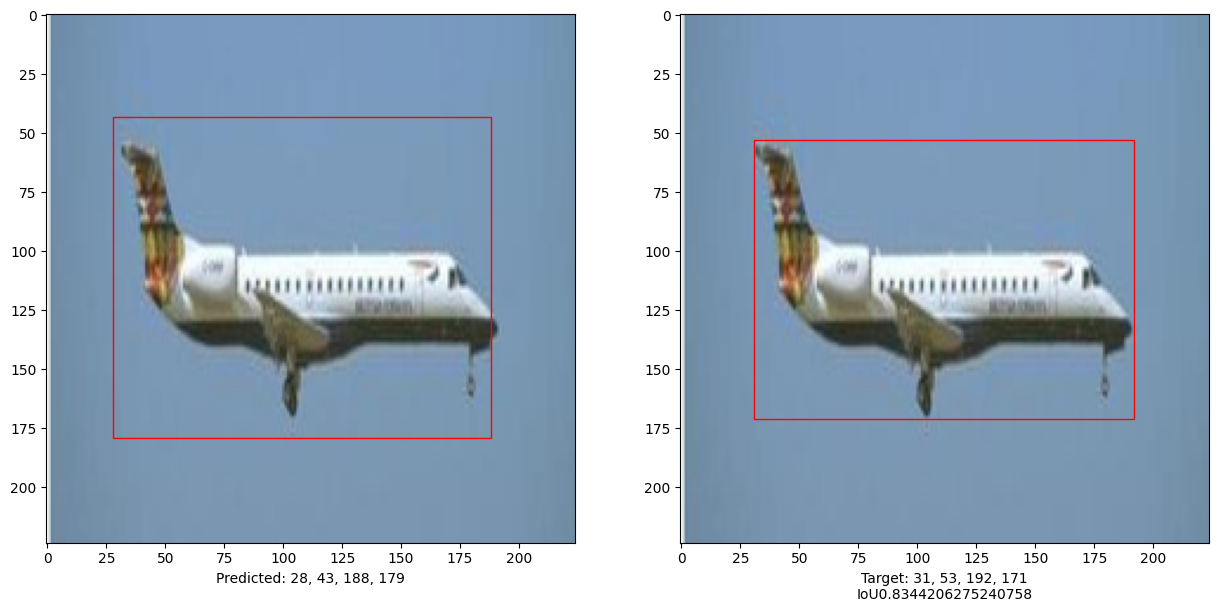

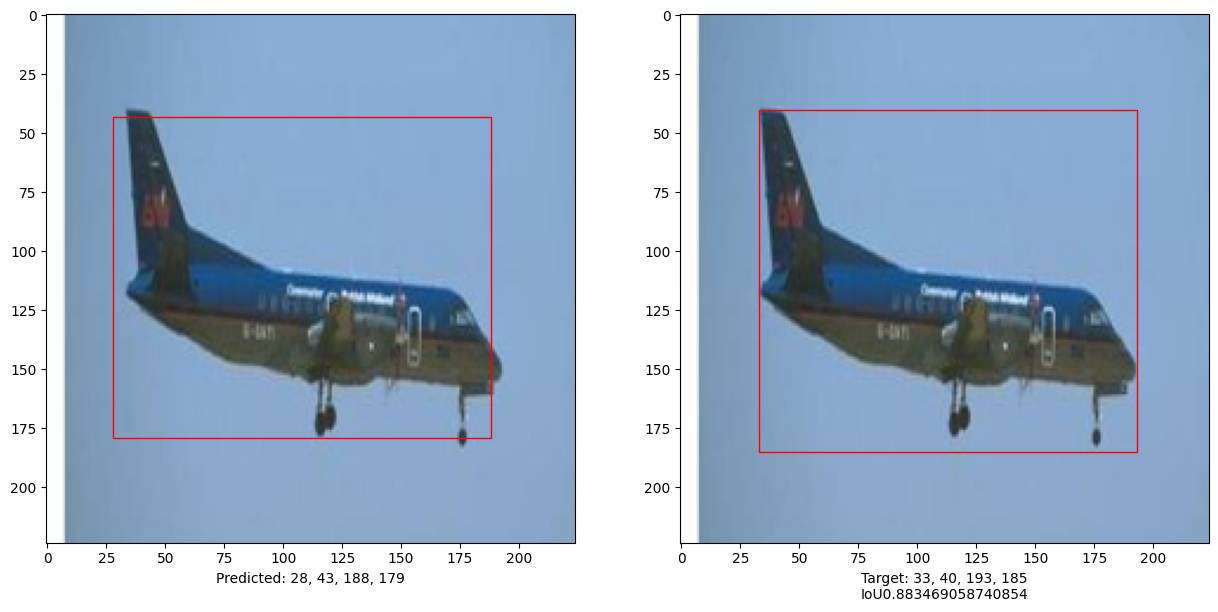

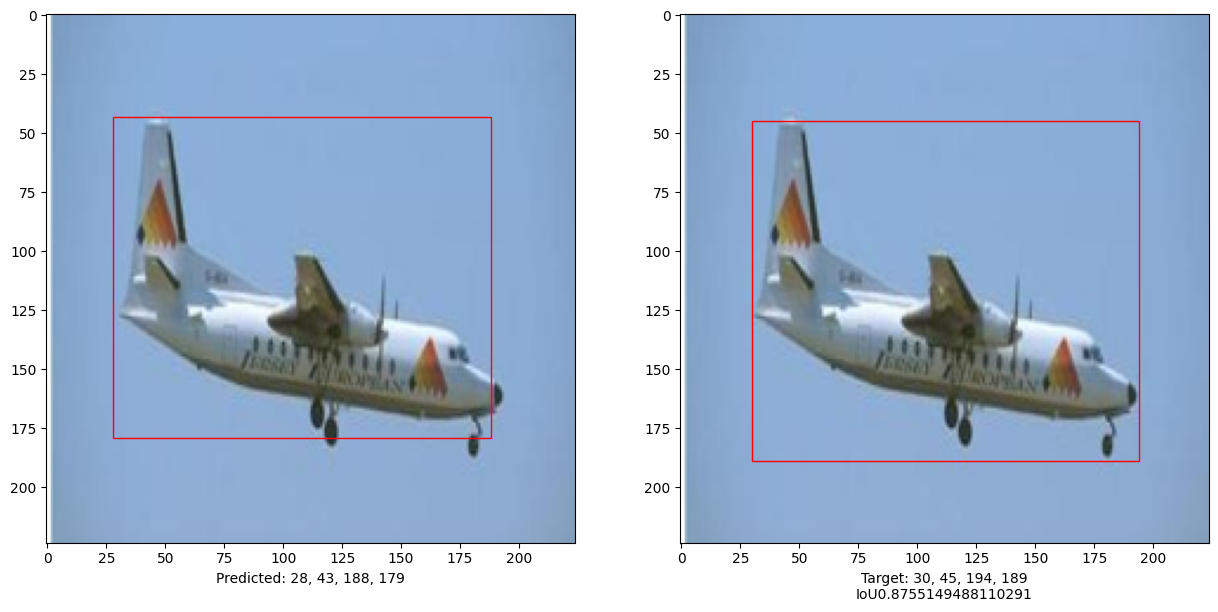

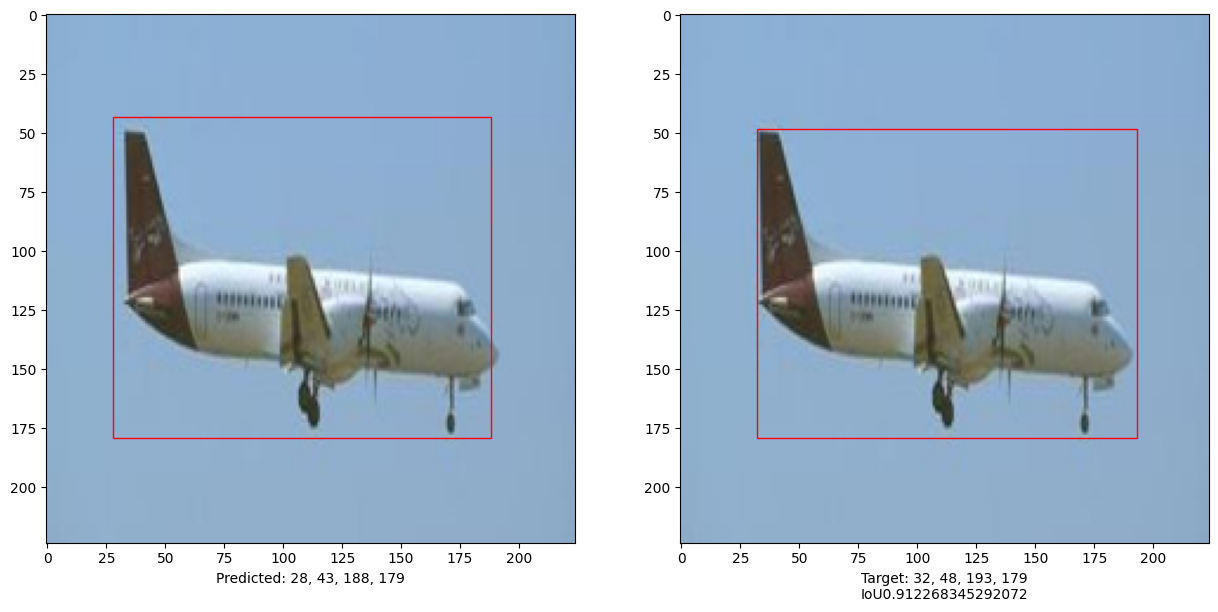

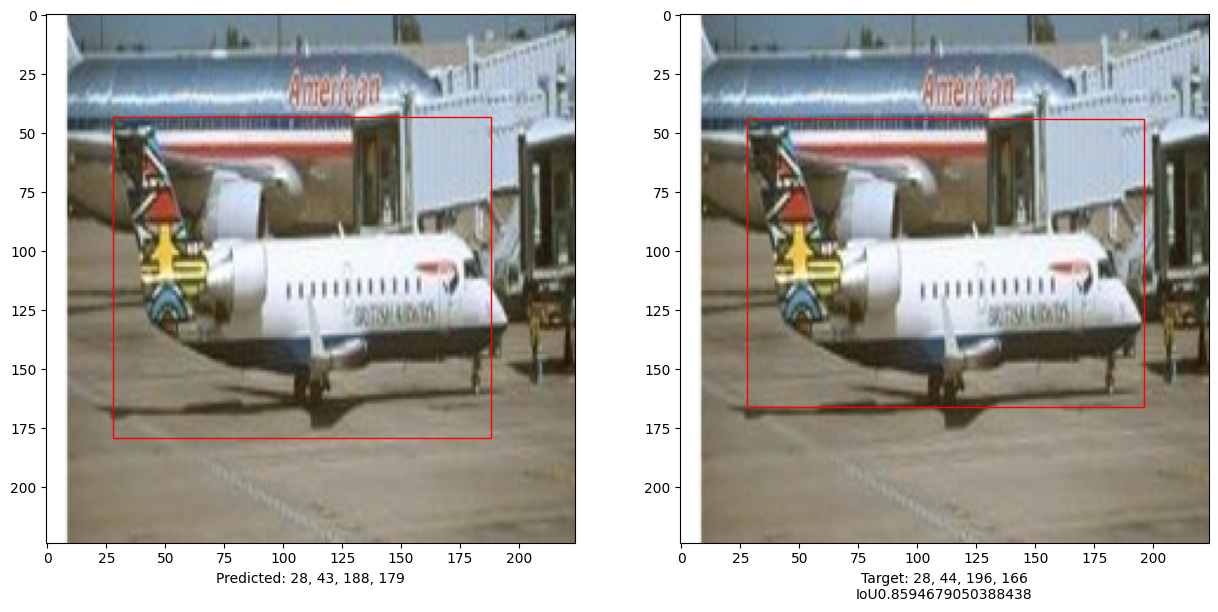

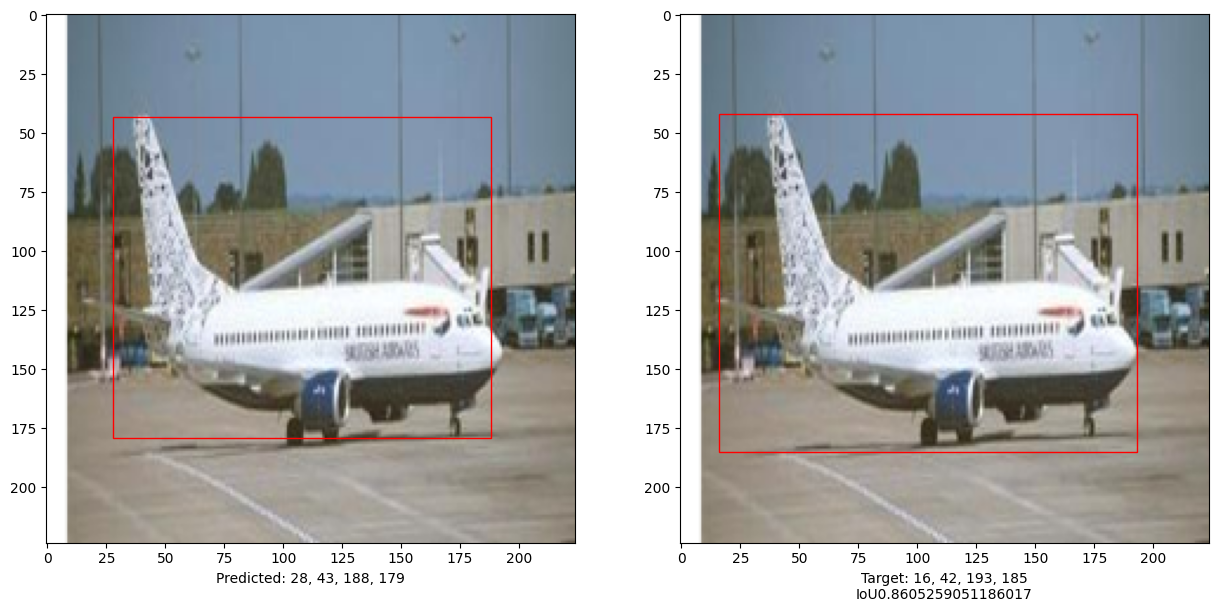

In [9]:
import matplotlib.patches as patches

# Saves the model in current path
vit_object_detector.save("vit_object_detector.keras")


# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()